In [1]:
# Python Free Fermion Large Scale Simulation Platform (FermiNet) Tutorials
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
# My PyFerm modules:
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import qiskit # Qiskit is required for this demo
import math

# Example 3: Multi-layer Circuit

The power of FermiNet really comes down to the fact that it can efficiently model a series of quantum gates, each corresponds to a continuous Hamiltonian time evolution, forming a multi-layer parameterized circuit. The network takes an input state denoted by a bitstring, and <b>computes the probability density value of observing any bitstring y in polynomial time of the number of qubits. </b>

More formally, a FermiNet object is a parameterized computing model $f_{\theta}(y;x)$, which takes in two bitstrings $y$ and $x$ and outputs the probability density $p(y|x)$. This model is multi-purpose, and can be used as a general quantum ansatz, a quantum generative/classification model, a classical quantum simulation platform for quantum systems, etc.

Here we demonstrate how to build a multi-layer parametrized quantum circuit with FermiNet classes and functions.

We define one circuit gate as $H_g$, and each gate corresponds to a continuous evolution $e^{-i\mathcal{H}t}$. A parametrized is a series of such evolutions:

$U_{total} = U_L U_{L-1}...U_{2} U_1, $

where $U_l$ is the $l$-th "layer" defined as:

$U_l = e^{-i\mathcal{H}_{l}t},$

where $\mathcal{H}_{l}$ concerns interactionos of two Fermionic modes $i<j$, not necessarily nearest-neighbor. In this example, we use a simple construction:

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{l} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

In [3]:
# Define the model configurations
N = 10
# Connectivity (i,j) of each "layer" where i<j.
conn_list = [ [np.min(p), np.max(p)] for p in get_nn_pairs(geometry=(N,))]*3 # zero indexed and should not be periodic (not a closed circle)
L = len(conn_list)
print('Connectivity list: ', conn_list)
print('Total layers: ', L)

Connectivity list:  [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [1, 2], [3, 4], [5, 6], [7, 8], [0, 9], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [1, 2], [3, 4], [5, 6], [7, 8], [0, 9], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [1, 2], [3, 4], [5, 6], [7, 8], [0, 9]]
Total layers:  30


In [4]:
# Define the circuit, calling the FermiNet "Network" class
circuit = Network(conn_list, N)

# Define an input state, in this case, a simple 1010...1010 basis state
# Note: x should follow the shape (batch_size, 2^N), even for a batch_size=1
x = torch.tensor([[1,0]*int(N/2)]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])

# When the circuit is initialized, the parameters are randomly initiailized by pi * Uniform([0,1]):
for param in circuit.parameters():
    print('Network parameters', param)

# Hereby we take an extra step to show you how to manually set these parameters:
params_m = torch.tensor(math.pi) * torch.rand((L, 4)) # Each layer has 4 rotations
print('params_m',params_m)

circuit.manual_set_params(params_m)

debug self.L 30
Network parameters Parameter containing:
tensor([0.9158], requires_grad=True)
Network parameters Parameter containing:
tensor([3.1218], requires_grad=True)
Network parameters Parameter containing:
tensor([1.0447], requires_grad=True)
Network parameters Parameter containing:
tensor([2.1245], requires_grad=True)
Network parameters Parameter containing:
tensor([2.4018], requires_grad=True)
Network parameters Parameter containing:
tensor([1.4513], requires_grad=True)
Network parameters Parameter containing:
tensor([1.1423], requires_grad=True)
Network parameters Parameter containing:
tensor([0.6841], requires_grad=True)
Network parameters Parameter containing:
tensor([2.3530], requires_grad=True)
Network parameters Parameter containing:
tensor([0.8496], requires_grad=True)
Network parameters Parameter containing:
tensor([2.5629], requires_grad=True)
Network parameters Parameter containing:
tensor([1.1200], requires_grad=True)
Network parameters Parameter containing:
tensor(

In [21]:
# Compute the probabilities of observing all possible bitstrings
# FermiNet supports batch processing too!

probs = torch.zeros(2**N, dtype=torch.cfloat) # To collect the probability densitives evaluations
basis_m_n = torch.tensor(binary_basis(geometry=(N,)))

# This demonstrates how to process P(y|x) by batches: P(y_batch|x_batch) results in a batch of probabilities
batch_size = 16
n_batches = len(probs)//batch_size if len(probs)%batch_size == 0 else len(probs)//batch_size+1

ts = time.time()
for i in range(n_batches):
    y_batch = basis_m_n[batch_size*i : batch_size*(i+1)] # shape is (batch_size, 2^N)
    x_batch = x.repeat(y_batch.shape[0], 1) # shape is (batch_size, 2^N)
    
    # In this example, we measure all the qubits at the end, so the mask is 1111..111
    sub_mask_batch = (torch.tensor([ [1]*N ])).repeat(y_batch.shape[0], 1) # shape is (batch_size, 2^N)
    # call circuit.forward_partial_observation() to get the P(y|x) values
    probs_batch = circuit.forward_partial_observation(y_batch, x_batch, sub_mask_batch)
    # Now put these probs_batch values into correct positions
    probs[batch_size*i : batch_size*(i+1)] = probs_batch
print('probs', probs)
# The returned probs are torch tensors, so detach the gradients and convert to numpy:
probs = probs.detach().numpy().real

tf = time.time()
print('time lapsed: ', str(tf-ts))

probs tensor([0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
       grad_fn=<CopySlices>)
time lapsed:  1.0610277652740479


Text(0.5, 1.0, 'Fermion Simulation time lapsed 1.0610277652740479')

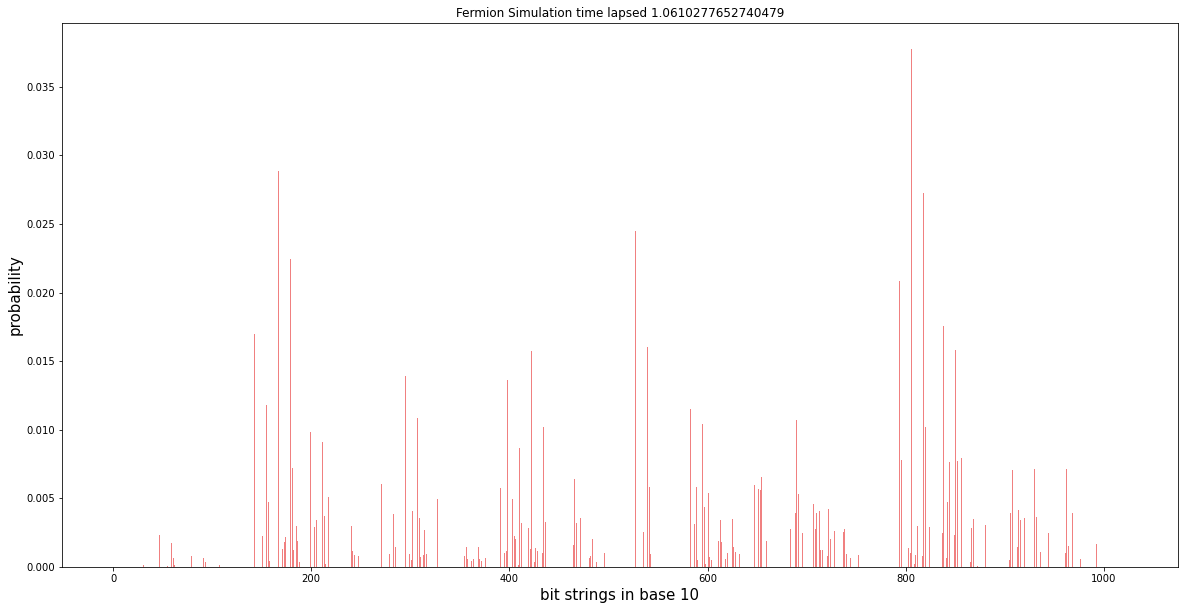

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = np.arange(2**N)
ax.bar(xs, probs, color='lightcoral')
ax.set_xlabel('bit strings in base 10', fontsize=15)
ax.set_ylabel('probability', fontsize=15)
ax.set_title('Fermion Simulation time lapsed '+str(tf-ts ))

# Compare with Exact Diagonalization 

Should we trust the Fermion simulations? Now let's compare the simulation results with exact diagonalization (ED). Notice how much faster the Fermion simulation runs!

In [23]:
x_string = '10'*int(N/2)+'1' if N%2==1 else '10'*int(N/2)
init_state_numpy = qiskit.quantum_info.Statevector.from_label(x_string).data

ts = time.time()
# Initialize the evolution matrix
exp_iH_exact = np.eye(2**N)
# Iterate each layer and get the composition via matrix multiplication
# Use the same params_m rotations defined earliers
for l in range(L):
    conn = conn_list[l]
    a, b, c, d = params_m.detach().numpy()[l]
    H_exact = initialize_sparse(N, conn[0], conn[1], a, b, c, d)
    exp_iH_exact = (scipy.linalg.expm(-1.0j*H_exact))@exp_iH_exact 

state_exact = np.matmul(exp_iH_exact, init_state_numpy[:,None])
probs_exact = (np.abs(state_exact)**2).squeeze()

tf = time.time()

debug a, b, c, d) (1.9955142, 1.7195914, 3.0341077, 2.3410141)
H_z   (0, 0)	-1.8575527667999268
  (1, 1)	-1.8575527667999268
  (2, 2)	-1.8575527667999268
  (3, 3)	-1.8575527667999268
  (4, 4)	-1.8575527667999268
  (5, 5)	-1.8575527667999268
  (6, 6)	-1.8575527667999268
  (7, 7)	-1.8575527667999268
  (8, 8)	-1.8575527667999268
  (9, 9)	-1.8575527667999268
  (10, 10)	-1.8575527667999268
  (11, 11)	-1.8575527667999268
  (12, 12)	-1.8575527667999268
  (13, 13)	-1.8575527667999268
  (14, 14)	-1.8575527667999268
  (15, 15)	-1.8575527667999268
  (16, 16)	-1.8575527667999268
  (17, 17)	-1.8575527667999268
  (18, 18)	-1.8575527667999268
  (19, 19)	-1.8575527667999268
  (20, 20)	-1.8575527667999268
  (21, 21)	-1.8575527667999268
  (22, 22)	-1.8575527667999268
  (23, 23)	-1.8575527667999268
  (24, 24)	-1.8575527667999268
  :	:
  (999, 999)	1.8575527667999268
  (1000, 1000)	1.8575527667999268
  (1001, 1001)	1.8575527667999268
  (1002, 1002)	1.8575527667999268
  (1003, 1003)	1.8575527667999268
  (1

debug a, b, c, d) (0.041700795, 2.2493808, 2.016191, 2.5865862)
H_z   (0, 0)	-1.1455408111214638
  (1, 1)	-1.1455408111214638
  (2, 2)	-1.1455408111214638
  (3, 3)	-1.1455408111214638
  (4, 4)	-1.1455408111214638
  (5, 5)	-1.1455408111214638
  (6, 6)	-1.1455408111214638
  (7, 7)	-1.1455408111214638
  (8, 8)	-1.1455408111214638
  (9, 9)	-1.1455408111214638
  (10, 10)	-1.1455408111214638
  (11, 11)	-1.1455408111214638
  (12, 12)	-1.1455408111214638
  (13, 13)	-1.1455408111214638
  (14, 14)	-1.1455408111214638
  (15, 15)	-1.1455408111214638
  (16, 16)	-1.1455408111214638
  (17, 17)	-1.1455408111214638
  (18, 18)	-1.1455408111214638
  (19, 19)	-1.1455408111214638
  (20, 20)	-1.1455408111214638
  (21, 21)	-1.1455408111214638
  (22, 22)	-1.1455408111214638
  (23, 23)	-1.1455408111214638
  (24, 24)	-1.1455408111214638
  :	:
  (999, 999)	1.1455408111214638
  (1000, 1000)	1.1455408111214638
  (1001, 1001)	1.1455408111214638
  (1002, 1002)	1.1455408111214638
  (1003, 1003)	1.1455408111214638
  (

debug a, b, c, d) (0.7918365, 2.5811095, 1.2477896, 1.0531982)
H_z   (0, 0)	-1.68647301197052
  (1, 1)	-1.68647301197052
  (2, 2)	-1.68647301197052
  (3, 3)	-1.68647301197052
  (4, 4)	-1.68647301197052
  (5, 5)	-1.68647301197052
  (6, 6)	-1.68647301197052
  (7, 7)	-1.68647301197052
  (8, 8)	-1.68647301197052
  (9, 9)	-1.68647301197052
  (10, 10)	-1.68647301197052
  (11, 11)	-1.68647301197052
  (12, 12)	-1.68647301197052
  (13, 13)	-1.68647301197052
  (14, 14)	-1.68647301197052
  (15, 15)	-1.68647301197052
  (16, 16)	0.8946365118026733
  (17, 17)	0.8946365118026733
  (18, 18)	0.8946365118026733
  (19, 19)	0.8946365118026733
  (20, 20)	0.8946365118026733
  (21, 21)	0.8946365118026733
  (22, 22)	0.8946365118026733
  (23, 23)	0.8946365118026733
  (24, 24)	0.8946365118026733
  :	:
  (999, 999)	-0.8946365118026733
  (1000, 1000)	-0.8946365118026733
  (1001, 1001)	-0.8946365118026733
  (1002, 1002)	-0.8946365118026733
  (1003, 1003)	-0.8946365118026733
  (1004, 1004)	-0.8946365118026733
  (10

debug a, b, c, d) (2.2610526, 2.9565723, 1.307026, 2.134193)
H_z   (0, 0)	-2.60881245136261
  (1, 1)	-2.60881245136261
  (2, 2)	-2.60881245136261
  (3, 3)	-2.60881245136261
  (4, 4)	0.34775984287261963
  (5, 5)	0.34775984287261963
  (6, 6)	0.34775984287261963
  (7, 7)	0.34775984287261963
  (8, 8)	-0.34775984287261963
  (9, 9)	-0.34775984287261963
  (10, 10)	-0.34775984287261963
  (11, 11)	-0.34775984287261963
  (12, 12)	2.60881245136261
  (13, 13)	2.60881245136261
  (14, 14)	2.60881245136261
  (15, 15)	2.60881245136261
  (16, 16)	-2.60881245136261
  (17, 17)	-2.60881245136261
  (18, 18)	-2.60881245136261
  (19, 19)	-2.60881245136261
  (20, 20)	0.34775984287261963
  (21, 21)	0.34775984287261963
  (22, 22)	0.34775984287261963
  (23, 23)	0.34775984287261963
  (24, 24)	-0.34775984287261963
  :	:
  (999, 999)	0.34775984287261963
  (1000, 1000)	-0.34775984287261963
  (1001, 1001)	-0.34775984287261963
  (1002, 1002)	-0.34775984287261963
  (1003, 1003)	-0.34775984287261963
  (1004, 1004)	2.608

debug a, b, c, d) (2.9940972, 1.5181553, 2.086864, 0.72680897)
H_z   (0, 0)	-2.256126284599304
  (1, 1)	-0.7379709482192993
  (2, 2)	0.7379709482192993
  (3, 3)	2.256126284599304
  (4, 4)	-2.256126284599304
  (5, 5)	-0.7379709482192993
  (6, 6)	0.7379709482192993
  (7, 7)	2.256126284599304
  (8, 8)	-2.256126284599304
  (9, 9)	-0.7379709482192993
  (10, 10)	0.7379709482192993
  (11, 11)	2.256126284599304
  (12, 12)	-2.256126284599304
  (13, 13)	-0.7379709482192993
  (14, 14)	0.7379709482192993
  (15, 15)	2.256126284599304
  (16, 16)	-2.256126284599304
  (17, 17)	-0.7379709482192993
  (18, 18)	0.7379709482192993
  (19, 19)	2.256126284599304
  (20, 20)	-2.256126284599304
  (21, 21)	-0.7379709482192993
  (22, 22)	0.7379709482192993
  (23, 23)	2.256126284599304
  (24, 24)	-2.256126284599304
  :	:
  (999, 999)	2.256126284599304
  (1000, 1000)	-2.256126284599304
  (1001, 1001)	-0.7379709482192993
  (1002, 1002)	0.7379709482192993
  (1003, 1003)	2.256126284599304
  (1004, 1004)	-2.256126284599

debug a, b, c, d) (0.07656909, 1.7635087, 0.93007964, 1.2084619)
H_z   (0, 0)	-0.9200388826429844
  (1, 1)	-0.9200388826429844
  (2, 2)	-0.9200388826429844
  (3, 3)	-0.9200388826429844
  (4, 4)	-0.9200388826429844
  (5, 5)	-0.9200388826429844
  (6, 6)	-0.9200388826429844
  (7, 7)	-0.9200388826429844
  (8, 8)	-0.9200388826429844
  (9, 9)	-0.9200388826429844
  (10, 10)	-0.9200388826429844
  (11, 11)	-0.9200388826429844
  (12, 12)	-0.9200388826429844
  (13, 13)	-0.9200388826429844
  (14, 14)	-0.9200388826429844
  (15, 15)	-0.9200388826429844
  (16, 16)	-0.9200388826429844
  (17, 17)	-0.9200388826429844
  (18, 18)	-0.9200388826429844
  (19, 19)	-0.9200388826429844
  (20, 20)	-0.9200388826429844
  (21, 21)	-0.9200388826429844
  (22, 22)	-0.9200388826429844
  (23, 23)	-0.9200388826429844
  (24, 24)	-0.9200388826429844
  :	:
  (999, 999)	0.9200388826429844
  (1000, 1000)	0.9200388826429844
  (1001, 1001)	0.9200388826429844
  (1002, 1002)	0.9200388826429844
  (1003, 1003)	0.9200388826429844
  

debug a, b, c, d) (2.9151452, 3.001517, 2.16516, 1.2563586)
H_z   (0, 0)	-2.9583311080932617
  (1, 1)	-2.9583311080932617
  (2, 2)	-2.9583311080932617
  (3, 3)	-2.9583311080932617
  (4, 4)	-2.9583311080932617
  (5, 5)	-2.9583311080932617
  (6, 6)	-2.9583311080932617
  (7, 7)	-2.9583311080932617
  (8, 8)	-2.9583311080932617
  (9, 9)	-2.9583311080932617
  (10, 10)	-2.9583311080932617
  (11, 11)	-2.9583311080932617
  (12, 12)	-2.9583311080932617
  (13, 13)	-2.9583311080932617
  (14, 14)	-2.9583311080932617
  (15, 15)	-2.9583311080932617
  (16, 16)	-2.9583311080932617
  (17, 17)	-2.9583311080932617
  (18, 18)	-2.9583311080932617
  (19, 19)	-2.9583311080932617
  (20, 20)	-2.9583311080932617
  (21, 21)	-2.9583311080932617
  (22, 22)	-2.9583311080932617
  (23, 23)	-2.9583311080932617
  (24, 24)	-2.9583311080932617
  :	:
  (999, 999)	2.9583311080932617
  (1000, 1000)	2.9583311080932617
  (1001, 1001)	2.9583311080932617
  (1002, 1002)	2.9583311080932617
  (1003, 1003)	2.9583311080932617
  (1004

debug a, b, c, d) (2.6601734, 0.48576653, 2.4127228, 2.7578504)
H_z   (0, 0)	-1.5729699730873108
  (1, 1)	-1.5729699730873108
  (2, 2)	-1.5729699730873108
  (3, 3)	-1.5729699730873108
  (4, 4)	-1.5729699730873108
  (5, 5)	-1.5729699730873108
  (6, 6)	-1.5729699730873108
  (7, 7)	-1.5729699730873108
  (8, 8)	-1.0872034430503845
  (9, 9)	-1.0872034430503845
  (10, 10)	-1.0872034430503845
  (11, 11)	-1.0872034430503845
  (12, 12)	-1.0872034430503845
  (13, 13)	-1.0872034430503845
  (14, 14)	-1.0872034430503845
  (15, 15)	-1.0872034430503845
  (16, 16)	1.0872034430503845
  (17, 17)	1.0872034430503845
  (18, 18)	1.0872034430503845
  (19, 19)	1.0872034430503845
  (20, 20)	1.0872034430503845
  (21, 21)	1.0872034430503845
  (22, 22)	1.0872034430503845
  (23, 23)	1.0872034430503845
  (24, 24)	1.5729699730873108
  :	:
  (999, 999)	-1.5729699730873108
  (1000, 1000)	-1.0872034430503845
  (1001, 1001)	-1.0872034430503845
  (1002, 1002)	-1.0872034430503845
  (1003, 1003)	-1.0872034430503845
  (1004

debug a, b, c, d) (0.6294027, 0.8827114, 1.7121881, 2.1986332)
H_z   (0, 0)	-0.7560570538043976
  (1, 1)	-0.7560570538043976
  (2, 2)	0.12665435671806335
  (3, 3)	0.12665435671806335
  (4, 4)	-0.12665435671806335
  (5, 5)	-0.12665435671806335
  (6, 6)	0.7560570538043976
  (7, 7)	0.7560570538043976
  (8, 8)	-0.7560570538043976
  (9, 9)	-0.7560570538043976
  (10, 10)	0.12665435671806335
  (11, 11)	0.12665435671806335
  (12, 12)	-0.12665435671806335
  (13, 13)	-0.12665435671806335
  (14, 14)	0.7560570538043976
  (15, 15)	0.7560570538043976
  (16, 16)	-0.7560570538043976
  (17, 17)	-0.7560570538043976
  (18, 18)	0.12665435671806335
  (19, 19)	0.12665435671806335
  (20, 20)	-0.12665435671806335
  (21, 21)	-0.12665435671806335
  (22, 22)	0.7560570538043976
  (23, 23)	0.7560570538043976
  (24, 24)	-0.7560570538043976
  :	:
  (999, 999)	0.7560570538043976
  (1000, 1000)	-0.7560570538043976
  (1001, 1001)	-0.7560570538043976
  (1002, 1002)	0.12665435671806335
  (1003, 1003)	0.12665435671806335


debug a, b, c, d) (0.9603394, 0.055394083, 2.5589347, 1.0673393)
H_z   (0, 0)	-0.5078667551279068
  (1, 1)	-0.45247267186641693
  (2, 2)	-0.5078667551279068
  (3, 3)	-0.45247267186641693
  (4, 4)	-0.5078667551279068
  (5, 5)	-0.45247267186641693
  (6, 6)	-0.5078667551279068
  (7, 7)	-0.45247267186641693
  (8, 8)	-0.5078667551279068
  (9, 9)	-0.45247267186641693
  (10, 10)	-0.5078667551279068
  (11, 11)	-0.45247267186641693
  (12, 12)	-0.5078667551279068
  (13, 13)	-0.45247267186641693
  (14, 14)	-0.5078667551279068
  (15, 15)	-0.45247267186641693
  (16, 16)	-0.5078667551279068
  (17, 17)	-0.45247267186641693
  (18, 18)	-0.5078667551279068
  (19, 19)	-0.45247267186641693
  (20, 20)	-0.5078667551279068
  (21, 21)	-0.45247267186641693
  (22, 22)	-0.5078667551279068
  (23, 23)	-0.45247267186641693
  (24, 24)	-0.5078667551279068
  :	:
  (999, 999)	0.5078667551279068
  (1000, 1000)	0.45247267186641693
  (1001, 1001)	0.5078667551279068
  (1002, 1002)	0.45247267186641693
  (1003, 1003)	0.50786

debug a, b, c, d) (2.2997303, 1.6630895, 1.0845702, 0.8755903)
H_z   (0, 0)	-1.9814099073410034
  (1, 1)	-1.9814099073410034
  (2, 2)	-1.9814099073410034
  (3, 3)	-1.9814099073410034
  (4, 4)	-1.9814099073410034
  (5, 5)	-1.9814099073410034
  (6, 6)	-1.9814099073410034
  (7, 7)	-1.9814099073410034
  (8, 8)	-1.9814099073410034
  (9, 9)	-1.9814099073410034
  (10, 10)	-1.9814099073410034
  (11, 11)	-1.9814099073410034
  (12, 12)	-1.9814099073410034
  (13, 13)	-1.9814099073410034
  (14, 14)	-1.9814099073410034
  (15, 15)	-1.9814099073410034
  (16, 16)	-1.9814099073410034
  (17, 17)	-1.9814099073410034
  (18, 18)	-1.9814099073410034
  (19, 19)	-1.9814099073410034
  (20, 20)	-1.9814099073410034
  (21, 21)	-1.9814099073410034
  (22, 22)	-1.9814099073410034
  (23, 23)	-1.9814099073410034
  (24, 24)	-1.9814099073410034
  :	:
  (999, 999)	1.9814099073410034
  (1000, 1000)	1.9814099073410034
  (1001, 1001)	1.9814099073410034
  (1002, 1002)	1.9814099073410034
  (1003, 1003)	1.9814099073410034
  (1

debug a, b, c, d) (2.8614013, 2.9506786, 2.85134, 0.14771737)
H_z   (0, 0)	-2.9060399532318115
  (1, 1)	-2.9060399532318115
  (2, 2)	-2.9060399532318115
  (3, 3)	-2.9060399532318115
  (4, 4)	-2.9060399532318115
  (5, 5)	-2.9060399532318115
  (6, 6)	-2.9060399532318115
  (7, 7)	-2.9060399532318115
  (8, 8)	-2.9060399532318115
  (9, 9)	-2.9060399532318115
  (10, 10)	-2.9060399532318115
  (11, 11)	-2.9060399532318115
  (12, 12)	-2.9060399532318115
  (13, 13)	-2.9060399532318115
  (14, 14)	-2.9060399532318115
  (15, 15)	-2.9060399532318115
  (16, 16)	-2.9060399532318115
  (17, 17)	-2.9060399532318115
  (18, 18)	-2.9060399532318115
  (19, 19)	-2.9060399532318115
  (20, 20)	-2.9060399532318115
  (21, 21)	-2.9060399532318115
  (22, 22)	-2.9060399532318115
  (23, 23)	-2.9060399532318115
  (24, 24)	-2.9060399532318115
  :	:
  (999, 999)	2.9060399532318115
  (1000, 1000)	2.9060399532318115
  (1001, 1001)	2.9060399532318115
  (1002, 1002)	2.9060399532318115
  (1003, 1003)	2.9060399532318115
  (10

debug a, b, c, d) (0.72699493, 0.76877904, 0.47865707, 2.212806)
H_z   (0, 0)	-0.74788698554039
  (1, 1)	-0.74788698554039
  (2, 2)	-0.74788698554039
  (3, 3)	-0.74788698554039
  (4, 4)	-0.74788698554039
  (5, 5)	-0.74788698554039
  (6, 6)	-0.74788698554039
  (7, 7)	-0.74788698554039
  (8, 8)	-0.74788698554039
  (9, 9)	-0.74788698554039
  (10, 10)	-0.74788698554039
  (11, 11)	-0.74788698554039
  (12, 12)	-0.74788698554039
  (13, 13)	-0.74788698554039
  (14, 14)	-0.74788698554039
  (15, 15)	-0.74788698554039
  (16, 16)	0.020892053842544556
  (17, 17)	0.020892053842544556
  (18, 18)	0.020892053842544556
  (19, 19)	0.020892053842544556
  (20, 20)	0.020892053842544556
  (21, 21)	0.020892053842544556
  (22, 22)	0.020892053842544556
  (23, 23)	0.020892053842544556
  (24, 24)	0.020892053842544556
  :	:
  (999, 999)	-0.020892053842544556
  (1000, 1000)	-0.020892053842544556
  (1001, 1001)	-0.020892053842544556
  (1002, 1002)	-0.020892053842544556
  (1003, 1003)	-0.020892053842544556
  (1004, 1

debug a, b, c, d) (0.83201176, 0.43229234, 0.3609911, 2.0903676)
H_z   (0, 0)	-0.6321520507335663
  (1, 1)	-0.6321520507335663
  (2, 2)	-0.6321520507335663
  (3, 3)	-0.6321520507335663
  (4, 4)	-0.19985970854759216
  (5, 5)	-0.19985970854759216
  (6, 6)	-0.19985970854759216
  (7, 7)	-0.19985970854759216
  (8, 8)	0.19985970854759216
  (9, 9)	0.19985970854759216
  (10, 10)	0.19985970854759216
  (11, 11)	0.19985970854759216
  (12, 12)	0.6321520507335663
  (13, 13)	0.6321520507335663
  (14, 14)	0.6321520507335663
  (15, 15)	0.6321520507335663
  (16, 16)	-0.6321520507335663
  (17, 17)	-0.6321520507335663
  (18, 18)	-0.6321520507335663
  (19, 19)	-0.6321520507335663
  (20, 20)	-0.19985970854759216
  (21, 21)	-0.19985970854759216
  (22, 22)	-0.19985970854759216
  (23, 23)	-0.19985970854759216
  (24, 24)	0.19985970854759216
  :	:
  (999, 999)	-0.19985970854759216
  (1000, 1000)	0.19985970854759216
  (1001, 1001)	0.19985970854759216
  (1002, 1002)	0.19985970854759216
  (1003, 1003)	0.1998597085

debug a, b, c, d) (2.0477011, 1.0892228, 2.4315984, 3.0948446)
H_z   (0, 0)	-1.5684619545936584
  (1, 1)	-0.47923916578292847
  (2, 2)	0.47923916578292847
  (3, 3)	1.5684619545936584
  (4, 4)	-1.5684619545936584
  (5, 5)	-0.47923916578292847
  (6, 6)	0.47923916578292847
  (7, 7)	1.5684619545936584
  (8, 8)	-1.5684619545936584
  (9, 9)	-0.47923916578292847
  (10, 10)	0.47923916578292847
  (11, 11)	1.5684619545936584
  (12, 12)	-1.5684619545936584
  (13, 13)	-0.47923916578292847
  (14, 14)	0.47923916578292847
  (15, 15)	1.5684619545936584
  (16, 16)	-1.5684619545936584
  (17, 17)	-0.47923916578292847
  (18, 18)	0.47923916578292847
  (19, 19)	1.5684619545936584
  (20, 20)	-1.5684619545936584
  (21, 21)	-0.47923916578292847
  (22, 22)	0.47923916578292847
  (23, 23)	1.5684619545936584
  (24, 24)	-1.5684619545936584
  :	:
  (999, 999)	1.5684619545936584
  (1000, 1000)	-1.5684619545936584
  (1001, 1001)	-0.47923916578292847
  (1002, 1002)	0.47923916578292847
  (1003, 1003)	1.5684619545936584


debug a, b, c, d) (2.1381462, 0.5230021, 3.0130184, 0.8660142)
H_z   (0, 0)	-1.3305741250514984
  (1, 1)	-1.3305741250514984
  (2, 2)	-1.3305741250514984
  (3, 3)	-1.3305741250514984
  (4, 4)	-1.3305741250514984
  (5, 5)	-1.3305741250514984
  (6, 6)	-1.3305741250514984
  (7, 7)	-1.3305741250514984
  (8, 8)	-1.3305741250514984
  (9, 9)	-1.3305741250514984
  (10, 10)	-1.3305741250514984
  (11, 11)	-1.3305741250514984
  (12, 12)	-1.3305741250514984
  (13, 13)	-1.3305741250514984
  (14, 14)	-1.3305741250514984
  (15, 15)	-1.3305741250514984
  (16, 16)	-1.3305741250514984
  (17, 17)	-1.3305741250514984
  (18, 18)	-1.3305741250514984
  (19, 19)	-1.3305741250514984
  (20, 20)	-1.3305741250514984
  (21, 21)	-1.3305741250514984
  (22, 22)	-1.3305741250514984
  (23, 23)	-1.3305741250514984
  (24, 24)	-1.3305741250514984
  :	:
  (999, 999)	1.3305741250514984
  (1000, 1000)	1.3305741250514984
  (1001, 1001)	1.3305741250514984
  (1002, 1002)	1.3305741250514984
  (1003, 1003)	1.3305741250514984
  (1

debug a, b, c, d) (0.43720907, 0.81194776, 0.75195843, 1.6929615)
H_z   (0, 0)	-0.6245784163475037
  (1, 1)	-0.6245784163475037
  (2, 2)	-0.6245784163475037
  (3, 3)	-0.6245784163475037
  (4, 4)	-0.6245784163475037
  (5, 5)	-0.6245784163475037
  (6, 6)	-0.6245784163475037
  (7, 7)	-0.6245784163475037
  (8, 8)	-0.6245784163475037
  (9, 9)	-0.6245784163475037
  (10, 10)	-0.6245784163475037
  (11, 11)	-0.6245784163475037
  (12, 12)	-0.6245784163475037
  (13, 13)	-0.6245784163475037
  (14, 14)	-0.6245784163475037
  (15, 15)	-0.6245784163475037
  (16, 16)	-0.6245784163475037
  (17, 17)	-0.6245784163475037
  (18, 18)	-0.6245784163475037
  (19, 19)	-0.6245784163475037
  (20, 20)	-0.6245784163475037
  (21, 21)	-0.6245784163475037
  (22, 22)	-0.6245784163475037
  (23, 23)	-0.6245784163475037
  (24, 24)	-0.6245784163475037
  :	:
  (999, 999)	0.6245784163475037
  (1000, 1000)	0.6245784163475037
  (1001, 1001)	0.6245784163475037
  (1002, 1002)	0.6245784163475037
  (1003, 1003)	0.6245784163475037
 

debug a, b, c, d) (2.4424748, 0.57991964, 1.072789, 0.7612657)
H_z   (0, 0)	-1.5111972391605377
  (1, 1)	-1.5111972391605377
  (2, 2)	-1.5111972391605377
  (3, 3)	-1.5111972391605377
  (4, 4)	-1.5111972391605377
  (5, 5)	-1.5111972391605377
  (6, 6)	-1.5111972391605377
  (7, 7)	-1.5111972391605377
  (8, 8)	-0.9312776029109955
  (9, 9)	-0.9312776029109955
  (10, 10)	-0.9312776029109955
  (11, 11)	-0.9312776029109955
  (12, 12)	-0.9312776029109955
  (13, 13)	-0.9312776029109955
  (14, 14)	-0.9312776029109955
  (15, 15)	-0.9312776029109955
  (16, 16)	0.9312776029109955
  (17, 17)	0.9312776029109955
  (18, 18)	0.9312776029109955
  (19, 19)	0.9312776029109955
  (20, 20)	0.9312776029109955
  (21, 21)	0.9312776029109955
  (22, 22)	0.9312776029109955
  (23, 23)	0.9312776029109955
  (24, 24)	1.5111972391605377
  :	:
  (999, 999)	-1.5111972391605377
  (1000, 1000)	-0.9312776029109955
  (1001, 1001)	-0.9312776029109955
  (1002, 1002)	-0.9312776029109955
  (1003, 1003)	-0.9312776029109955
  (1004,

debug a, b, c, d) (0.8025433, 2.794452, 0.4347392, 0.40093413)
H_z   (0, 0)	-1.7984976172447205
  (1, 1)	-1.7984976172447205
  (2, 2)	0.9959543347358704
  (3, 3)	0.9959543347358704
  (4, 4)	-0.9959543347358704
  (5, 5)	-0.9959543347358704
  (6, 6)	1.7984976172447205
  (7, 7)	1.7984976172447205
  (8, 8)	-1.7984976172447205
  (9, 9)	-1.7984976172447205
  (10, 10)	0.9959543347358704
  (11, 11)	0.9959543347358704
  (12, 12)	-0.9959543347358704
  (13, 13)	-0.9959543347358704
  (14, 14)	1.7984976172447205
  (15, 15)	1.7984976172447205
  (16, 16)	-1.7984976172447205
  (17, 17)	-1.7984976172447205
  (18, 18)	0.9959543347358704
  (19, 19)	0.9959543347358704
  (20, 20)	-0.9959543347358704
  (21, 21)	-0.9959543347358704
  (22, 22)	1.7984976172447205
  (23, 23)	1.7984976172447205
  (24, 24)	-1.7984976172447205
  :	:
  (999, 999)	1.7984976172447205
  (1000, 1000)	-1.7984976172447205
  (1001, 1001)	-1.7984976172447205
  (1002, 1002)	0.9959543347358704
  (1003, 1003)	0.9959543347358704
  (1004, 1004)

debug a, b, c, d) (1.9523764, 1.0658208, 1.8594015, 0.10124479)
H_z   (0, 0)	-1.5090985894203186
  (1, 1)	-0.4432777762413025
  (2, 2)	-1.5090985894203186
  (3, 3)	-0.4432777762413025
  (4, 4)	-1.5090985894203186
  (5, 5)	-0.4432777762413025
  (6, 6)	-1.5090985894203186
  (7, 7)	-0.4432777762413025
  (8, 8)	-1.5090985894203186
  (9, 9)	-0.4432777762413025
  (10, 10)	-1.5090985894203186
  (11, 11)	-0.4432777762413025
  (12, 12)	-1.5090985894203186
  (13, 13)	-0.4432777762413025
  (14, 14)	-1.5090985894203186
  (15, 15)	-0.4432777762413025
  (16, 16)	-1.5090985894203186
  (17, 17)	-0.4432777762413025
  (18, 18)	-1.5090985894203186
  (19, 19)	-0.4432777762413025
  (20, 20)	-1.5090985894203186
  (21, 21)	-0.4432777762413025
  (22, 22)	-1.5090985894203186
  (23, 23)	-0.4432777762413025
  (24, 24)	-1.5090985894203186
  :	:
  (999, 999)	1.5090985894203186
  (1000, 1000)	0.4432777762413025
  (1001, 1001)	1.5090985894203186
  (1002, 1002)	0.4432777762413025
  (1003, 1003)	1.5090985894203186
  (

debug a, b, c, d) (1.8265953, 0.4311529, 2.9120426, 3.0874445)
H_z   (0, 0)	-1.1288741081953049
  (1, 1)	-1.1288741081953049
  (2, 2)	-1.1288741081953049
  (3, 3)	-1.1288741081953049
  (4, 4)	-1.1288741081953049
  (5, 5)	-1.1288741081953049
  (6, 6)	-1.1288741081953049
  (7, 7)	-1.1288741081953049
  (8, 8)	-1.1288741081953049
  (9, 9)	-1.1288741081953049
  (10, 10)	-1.1288741081953049
  (11, 11)	-1.1288741081953049
  (12, 12)	-1.1288741081953049
  (13, 13)	-1.1288741081953049
  (14, 14)	-1.1288741081953049
  (15, 15)	-1.1288741081953049
  (16, 16)	-1.1288741081953049
  (17, 17)	-1.1288741081953049
  (18, 18)	-1.1288741081953049
  (19, 19)	-1.1288741081953049
  (20, 20)	-1.1288741081953049
  (21, 21)	-1.1288741081953049
  (22, 22)	-1.1288741081953049
  (23, 23)	-1.1288741081953049
  (24, 24)	-1.1288741081953049
  :	:
  (999, 999)	1.1288741081953049
  (1000, 1000)	1.1288741081953049
  (1001, 1001)	1.1288741081953049
  (1002, 1002)	1.1288741081953049
  (1003, 1003)	1.1288741081953049
  (1

debug a, b, c, d) (0.8710131, 0.6502124, 3.0157137, 2.1117687)
H_z   (0, 0)	-0.7606127560138702
  (1, 1)	-0.7606127560138702
  (2, 2)	-0.7606127560138702
  (3, 3)	-0.7606127560138702
  (4, 4)	-0.7606127560138702
  (5, 5)	-0.7606127560138702
  (6, 6)	-0.7606127560138702
  (7, 7)	-0.7606127560138702
  (8, 8)	-0.7606127560138702
  (9, 9)	-0.7606127560138702
  (10, 10)	-0.7606127560138702
  (11, 11)	-0.7606127560138702
  (12, 12)	-0.7606127560138702
  (13, 13)	-0.7606127560138702
  (14, 14)	-0.7606127560138702
  (15, 15)	-0.7606127560138702
  (16, 16)	-0.7606127560138702
  (17, 17)	-0.7606127560138702
  (18, 18)	-0.7606127560138702
  (19, 19)	-0.7606127560138702
  (20, 20)	-0.7606127560138702
  (21, 21)	-0.7606127560138702
  (22, 22)	-0.7606127560138702
  (23, 23)	-0.7606127560138702
  (24, 24)	-0.7606127560138702
  :	:
  (999, 999)	0.7606127560138702
  (1000, 1000)	0.7606127560138702
  (1001, 1001)	0.7606127560138702
  (1002, 1002)	0.7606127560138702
  (1003, 1003)	0.7606127560138702
  (1

debug a, b, c, d) (0.57783157, 2.2017422, 1.3940808, 3.109528)
H_z   (0, 0)	-1.3897868692874908
  (1, 1)	-1.3897868692874908
  (2, 2)	-1.3897868692874908
  (3, 3)	-1.3897868692874908
  (4, 4)	-1.3897868692874908
  (5, 5)	-1.3897868692874908
  (6, 6)	-1.3897868692874908
  (7, 7)	-1.3897868692874908
  (8, 8)	-1.3897868692874908
  (9, 9)	-1.3897868692874908
  (10, 10)	-1.3897868692874908
  (11, 11)	-1.3897868692874908
  (12, 12)	-1.3897868692874908
  (13, 13)	-1.3897868692874908
  (14, 14)	-1.3897868692874908
  (15, 15)	-1.3897868692874908
  (16, 16)	0.8119553029537201
  (17, 17)	0.8119553029537201
  (18, 18)	0.8119553029537201
  (19, 19)	0.8119553029537201
  (20, 20)	0.8119553029537201
  (21, 21)	0.8119553029537201
  (22, 22)	0.8119553029537201
  (23, 23)	0.8119553029537201
  (24, 24)	0.8119553029537201
  :	:
  (999, 999)	-0.8119553029537201
  (1000, 1000)	-0.8119553029537201
  (1001, 1001)	-0.8119553029537201
  (1002, 1002)	-0.8119553029537201
  (1003, 1003)	-0.8119553029537201
  (1004,

debug a, b, c, d) (0.35900244, 2.0577984, 1.6317768, 1.4497772)
H_z   (0, 0)	-1.2084004133939743
  (1, 1)	-1.2084004133939743
  (2, 2)	-1.2084004133939743
  (3, 3)	-1.2084004133939743
  (4, 4)	0.8493979722261429
  (5, 5)	0.8493979722261429
  (6, 6)	0.8493979722261429
  (7, 7)	0.8493979722261429
  (8, 8)	-0.8493979722261429
  (9, 9)	-0.8493979722261429
  (10, 10)	-0.8493979722261429
  (11, 11)	-0.8493979722261429
  (12, 12)	1.2084004133939743
  (13, 13)	1.2084004133939743
  (14, 14)	1.2084004133939743
  (15, 15)	1.2084004133939743
  (16, 16)	-1.2084004133939743
  (17, 17)	-1.2084004133939743
  (18, 18)	-1.2084004133939743
  (19, 19)	-1.2084004133939743
  (20, 20)	0.8493979722261429
  (21, 21)	0.8493979722261429
  (22, 22)	0.8493979722261429
  (23, 23)	0.8493979722261429
  (24, 24)	-0.8493979722261429
  :	:
  (999, 999)	0.8493979722261429
  (1000, 1000)	-0.8493979722261429
  (1001, 1001)	-0.8493979722261429
  (1002, 1002)	-0.8493979722261429
  (1003, 1003)	-0.8493979722261429
  (1004, 10

debug a, b, c, d) (1.6358618, 0.5749917, 0.98512894, 2.6810863)
H_z   (0, 0)	-1.1054267287254333
  (1, 1)	-0.5304350256919861
  (2, 2)	0.5304350256919861
  (3, 3)	1.1054267287254333
  (4, 4)	-1.1054267287254333
  (5, 5)	-0.5304350256919861
  (6, 6)	0.5304350256919861
  (7, 7)	1.1054267287254333
  (8, 8)	-1.1054267287254333
  (9, 9)	-0.5304350256919861
  (10, 10)	0.5304350256919861
  (11, 11)	1.1054267287254333
  (12, 12)	-1.1054267287254333
  (13, 13)	-0.5304350256919861
  (14, 14)	0.5304350256919861
  (15, 15)	1.1054267287254333
  (16, 16)	-1.1054267287254333
  (17, 17)	-0.5304350256919861
  (18, 18)	0.5304350256919861
  (19, 19)	1.1054267287254333
  (20, 20)	-1.1054267287254333
  (21, 21)	-0.5304350256919861
  (22, 22)	0.5304350256919861
  (23, 23)	1.1054267287254333
  (24, 24)	-1.1054267287254333
  :	:
  (999, 999)	1.1054267287254333
  (1000, 1000)	-1.1054267287254333
  (1001, 1001)	-0.5304350256919861
  (1002, 1002)	0.5304350256919861
  (1003, 1003)	1.1054267287254333
  (1004, 1004

debug a, b, c, d) (2.3108258, 1.6469648, 1.9866372, 0.016589725)
H_z   (0, 0)	-1.9788953065872192
  (1, 1)	-1.9788953065872192
  (2, 2)	-1.9788953065872192
  (3, 3)	-1.9788953065872192
  (4, 4)	-1.9788953065872192
  (5, 5)	-1.9788953065872192
  (6, 6)	-1.9788953065872192
  (7, 7)	-1.9788953065872192
  (8, 8)	-1.9788953065872192
  (9, 9)	-1.9788953065872192
  (10, 10)	-1.9788953065872192
  (11, 11)	-1.9788953065872192
  (12, 12)	-1.9788953065872192
  (13, 13)	-1.9788953065872192
  (14, 14)	-1.9788953065872192
  (15, 15)	-1.9788953065872192
  (16, 16)	-1.9788953065872192
  (17, 17)	-1.9788953065872192
  (18, 18)	-1.9788953065872192
  (19, 19)	-1.9788953065872192
  (20, 20)	-1.9788953065872192
  (21, 21)	-1.9788953065872192
  (22, 22)	-1.9788953065872192
  (23, 23)	-1.9788953065872192
  (24, 24)	-1.9788953065872192
  :	:
  (999, 999)	1.9788953065872192
  (1000, 1000)	1.9788953065872192
  (1001, 1001)	1.9788953065872192
  (1002, 1002)	1.9788953065872192
  (1003, 1003)	1.9788953065872192
  

debug a, b, c, d) (2.4151177, 3.052968, 0.96254677, 1.065934)
H_z   (0, 0)	-2.7340428829193115
  (1, 1)	-2.7340428829193115
  (2, 2)	-2.7340428829193115
  (3, 3)	-2.7340428829193115
  (4, 4)	-2.7340428829193115
  (5, 5)	-2.7340428829193115
  (6, 6)	-2.7340428829193115
  (7, 7)	-2.7340428829193115
  (8, 8)	-2.7340428829193115
  (9, 9)	-2.7340428829193115
  (10, 10)	-2.7340428829193115
  (11, 11)	-2.7340428829193115
  (12, 12)	-2.7340428829193115
  (13, 13)	-2.7340428829193115
  (14, 14)	-2.7340428829193115
  (15, 15)	-2.7340428829193115
  (16, 16)	-2.7340428829193115
  (17, 17)	-2.7340428829193115
  (18, 18)	-2.7340428829193115
  (19, 19)	-2.7340428829193115
  (20, 20)	-2.7340428829193115
  (21, 21)	-2.7340428829193115
  (22, 22)	-2.7340428829193115
  (23, 23)	-2.7340428829193115
  (24, 24)	-2.7340428829193115
  :	:
  (999, 999)	2.7340428829193115
  (1000, 1000)	2.7340428829193115
  (1001, 1001)	2.7340428829193115
  (1002, 1002)	2.7340428829193115
  (1003, 1003)	2.7340428829193115
  (10

debug a, b, c, d) (3.0639665, 2.497803, 1.5202649, 0.3957723)
H_z   (0, 0)	-2.7808847427368164
  (1, 1)	-2.7808847427368164
  (2, 2)	-2.7808847427368164
  (3, 3)	-2.7808847427368164
  (4, 4)	-2.7808847427368164
  (5, 5)	-2.7808847427368164
  (6, 6)	-2.7808847427368164
  (7, 7)	-2.7808847427368164
  (8, 8)	-0.2830817699432373
  (9, 9)	-0.2830817699432373
  (10, 10)	-0.2830817699432373
  (11, 11)	-0.2830817699432373
  (12, 12)	-0.2830817699432373
  (13, 13)	-0.2830817699432373
  (14, 14)	-0.2830817699432373
  (15, 15)	-0.2830817699432373
  (16, 16)	0.2830817699432373
  (17, 17)	0.2830817699432373
  (18, 18)	0.2830817699432373
  (19, 19)	0.2830817699432373
  (20, 20)	0.2830817699432373
  (21, 21)	0.2830817699432373
  (22, 22)	0.2830817699432373
  (23, 23)	0.2830817699432373
  (24, 24)	2.7808847427368164
  :	:
  (999, 999)	-2.7808847427368164
  (1000, 1000)	-0.2830817699432373
  (1001, 1001)	-0.2830817699432373
  (1002, 1002)	-0.2830817699432373
  (1003, 1003)	-0.2830817699432373
  (1004, 

debug a, b, c, d) (2.967519, 1.5126373, 2.6950758, 2.374602)
H_z   (0, 0)	-2.2400781512260437
  (1, 1)	-2.2400781512260437
  (2, 2)	-0.7274408936500549
  (3, 3)	-0.7274408936500549
  (4, 4)	0.7274408936500549
  (5, 5)	0.7274408936500549
  (6, 6)	2.2400781512260437
  (7, 7)	2.2400781512260437
  (8, 8)	-2.2400781512260437
  (9, 9)	-2.2400781512260437
  (10, 10)	-0.7274408936500549
  (11, 11)	-0.7274408936500549
  (12, 12)	0.7274408936500549
  (13, 13)	0.7274408936500549
  (14, 14)	2.2400781512260437
  (15, 15)	2.2400781512260437
  (16, 16)	-2.2400781512260437
  (17, 17)	-2.2400781512260437
  (18, 18)	-0.7274408936500549
  (19, 19)	-0.7274408936500549
  (20, 20)	0.7274408936500549
  (21, 21)	0.7274408936500549
  (22, 22)	2.2400781512260437
  (23, 23)	2.2400781512260437
  (24, 24)	-2.2400781512260437
  :	:
  (999, 999)	2.2400781512260437
  (1000, 1000)	-2.2400781512260437
  (1001, 1001)	-2.2400781512260437
  (1002, 1002)	-0.7274408936500549
  (1003, 1003)	-0.7274408936500549
  (1004, 1004)

debug a, b, c, d) (1.9394588, 2.5812562, 1.6533196, 2.8620038)
H_z   (0, 0)	-2.2603574991226196
  (1, 1)	0.3208986520767212
  (2, 2)	-2.2603574991226196
  (3, 3)	0.3208986520767212
  (4, 4)	-2.2603574991226196
  (5, 5)	0.3208986520767212
  (6, 6)	-2.2603574991226196
  (7, 7)	0.3208986520767212
  (8, 8)	-2.2603574991226196
  (9, 9)	0.3208986520767212
  (10, 10)	-2.2603574991226196
  (11, 11)	0.3208986520767212
  (12, 12)	-2.2603574991226196
  (13, 13)	0.3208986520767212
  (14, 14)	-2.2603574991226196
  (15, 15)	0.3208986520767212
  (16, 16)	-2.2603574991226196
  (17, 17)	0.3208986520767212
  (18, 18)	-2.2603574991226196
  (19, 19)	0.3208986520767212
  (20, 20)	-2.2603574991226196
  (21, 21)	0.3208986520767212
  (22, 22)	-2.2603574991226196
  (23, 23)	0.3208986520767212
  (24, 24)	-2.2603574991226196
  :	:
  (999, 999)	2.2603574991226196
  (1000, 1000)	-0.3208986520767212
  (1001, 1001)	2.2603574991226196
  (1002, 1002)	-0.3208986520767212
  (1003, 1003)	2.2603574991226196
  (1004, 1004)

Text(0.5, 1.0, 'Exact Diagonalization time lapsed 24.15604591369629')

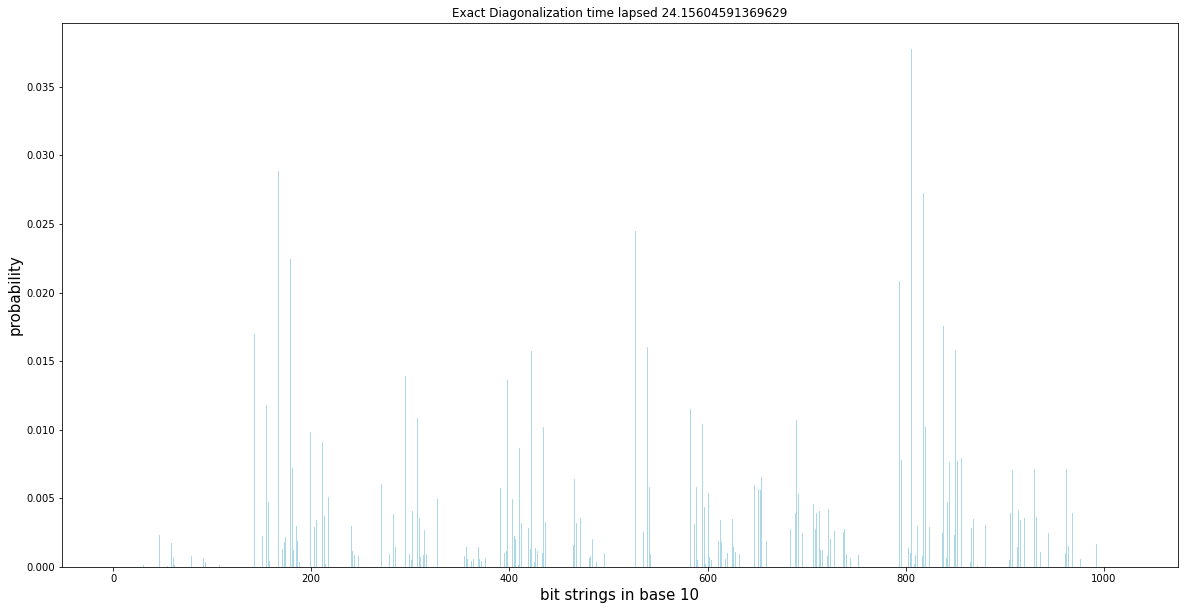

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = np.arange(2**N)
ax.bar(xs, probs_exact, color='lightblue')
ax.set_xlabel('bit strings in base 10', fontsize=15)
ax.set_ylabel('probability', fontsize=15)
ax.set_title('Exact Diagonalization time lapsed '+str(tf-ts ))

Text(0.5, 1.0, 'Total variation: 1.011005269815707e-12')

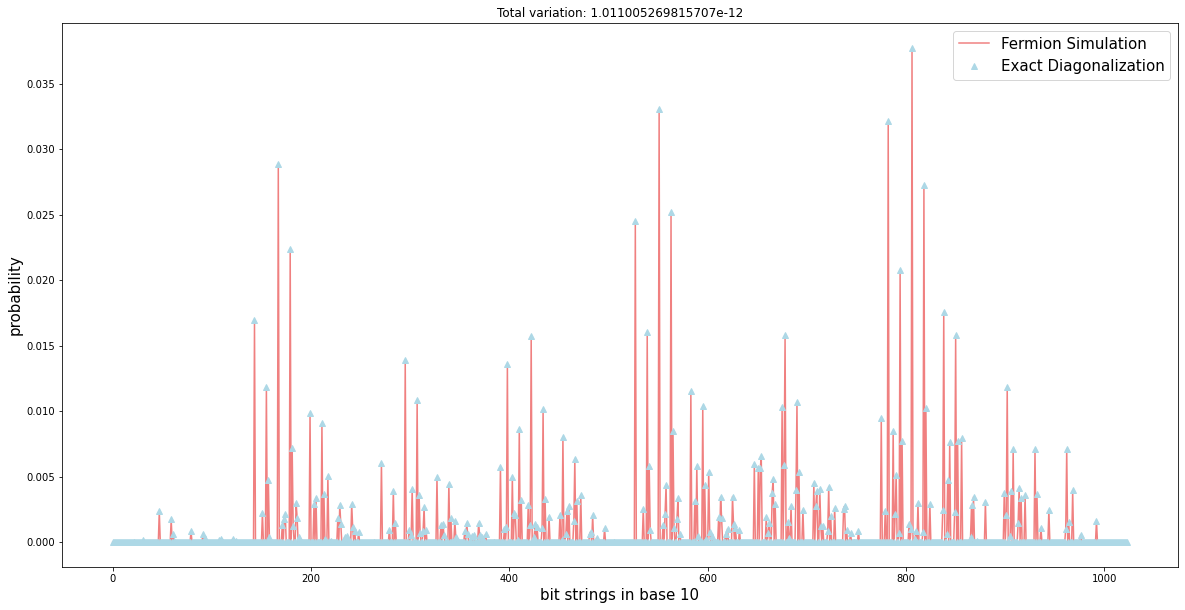

In [30]:
# Plot two against each other
fig, ax = plt.subplots(figsize=(20, 10))
xs = np.arange(2**N)
ax.plot(xs, probs, color='lightcoral')
ax.plot(xs, probs_exact, '^', color='lightblue')

ax.set_xlabel('bit strings in base 10', fontsize=15)
ax.set_ylabel('probability', fontsize=15)

ax.legend(['Fermion Simulation', 'Exact Diagonalization'], fontsize=15)
tv = (np.abs(probs-probs_exact)**2).sum()
ax.set_title('Total variation: '+str(tv))